In [1]:
import os, sys

import re
import json
import glob
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

%config InlineBackend.figure_format='retina'

## Gold Reward

In [62]:
GOLD_PATH = "/home/mb1921/pluralistic_rlhf/experiments/exp1_oracle/results/ppo_eval/imdb_gold_combined.csv"

gold_combined_df = pd.read_csv(GOLD_PATH)
gold_combined_df = gold_combined_df.groupby("query_id", group_keys=False).sample(n=1, random_state=42)
gold_combined_df["majority_score"] = gold_combined_df["ppo_conciseness"]
gold_combined_df["minority_score"] = 0.7*gold_combined_df["ppo_positiveness"] + 0.3*gold_combined_df["ppo_conciseness"]
gold_combined_df.head(3)

,Unnamed: 0,review,query,responses,query_id,token_length,normalized_token_length,positiveness,ppo_responses,ppo_token_length,ppo_conciseness,ppo_positiveness,seed,majority_score,minority_score
0,0,I love sci-fi and am willing to put up with a ...,I love sci-fi and am,I love sci-fi and am so used to seeing a movie...,0,99,0.961165,0.481773,I love sci-fi and am a huge fan of the original.,14,0.864078,0.978883,73,0.864078,0.944441
450003,3,"Worth the entertainment value of a rental, esp...",Worth the entertainment value of a,Worth the entertainment value of a good movie....,1,99,0.961165,0.159437,Worth the entertainment value of a DVD.,9,0.910891,0.982986,14,0.910891,0.961357
250004,4,its a totally average film with a few semi-alr...,its a totally,its a totally different way of viewing things....,2,41,0.398058,0.981294,its a totally enjoyable movie.,6,0.941176,0.994904,94,0.941176,0.978786


In [63]:
mean_gold_min_score = gold_combined_df["minority_score"].mean().item()
sem_gold_min_score = gold_combined_df["minority_score"].sem().item()

mean_gold_maj_score = gold_combined_df["majority_score"].mean().item()
sem_gold_maj_score = gold_combined_df["majority_score"].sem().item()

print("- Mean Gold Minority Score:", mean_gold_min_score)
print("- SEM Gold Minority Score:", sem_gold_min_score)
print()
print("- Mean Gold Majority Score:", mean_gold_maj_score)
print("- SEM Gold Majority Score:", sem_gold_maj_score)   

- Mean Gold Minority Score: 0.8084136299465374
- SEM Gold Minority Score: 0.001445409734884519

- Mean Gold Majority Score: 0.847841396429763
- SEM Gold Majority Score: 0.0005405260297135759


## Maxmin

In [4]:
EXP_MAXMIN = "/home/mb1921/pluralistic_rlhf/experiments/exp1_standard_maxmin_pointwise_inv_pref"
df_maxmin = pd.read_csv(EXP_MAXMIN+"/results/ppo_eval/result.csv")
df_maxmin

,Conciseness,Positiveness,seed,Minority Proportion,Score Majority Group,Score Minority Group
0,0.019802,0.990180,4,0.01,0.019802,0.699067
1,0.871287,0.989905,4,0.01,0.871287,0.954320
2,0.544554,0.039391,4,0.01,0.544554,0.190940
3,0.930693,0.943660,4,0.01,0.930693,0.939770
4,0.059406,0.994997,4,0.01,0.059406,0.714320
...,...,...,...,...,...,...
999995,0.930693,0.880647,113,0.20,0.930693,0.895661
999996,0.910891,0.924088,113,0.20,0.910891,0.920129
999997,0.920792,0.234868,113,0.20,0.920792,0.440645
999998,0.900990,0.008576,113,0.20,0.900990,0.276300


## SharedPref

### Ablation

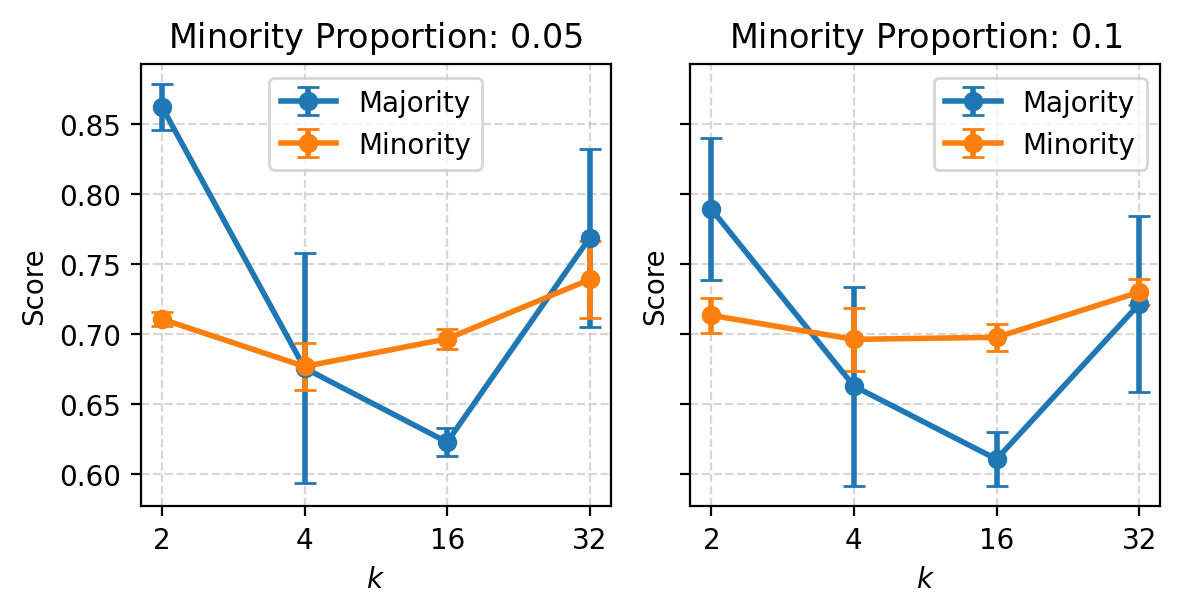

In [27]:
df_sharedpref = pd.read_csv("/home/mb1921/pluralistic_rlhf/experiments/shared_pref_pointwise_ablation_inv_pref/results/results.csv.")


# Get unique values for faceting and grouping
minority_props = sorted(df_sharedpref["Minority Proportion"].unique())
groups = sorted(df_sharedpref["Group"].unique())

# Save Data for Latex plot
df_latex = pd.DataFrame({
    "k": [],
    "mean_minority_score": [],
    "se_minority_score":[],
    "mean_majority_score": [],
    "se_majority_score":[],
})

# Set up subplots: one per Minority Proportion
fig, axes = plt.subplots(
    1, len(minority_props),
    figsize=(6 , 3.2),
    sharey=True
)

# Make axes iterable if only one subplot
if len(minority_props) == 1:
    axes = [axes]

for ax, minority in zip(axes, minority_props):
    df_subset = df_sharedpref[df_sharedpref["Minority Proportion"] == minority]

    # Determine unique k values and convert to categorical (strings)
    ks = sorted(df_subset["k"].unique())
    ks_str = list(map(str, ks))

    df_latex["k"] = ks_str

    for group in groups:
        df_group = df_subset[df_subset["Group"] == group]

        # Compute mean and standard error for each k
        means = df_group.groupby("k")["Score"].mean().reindex(ks)
        ses = df_group.groupby("k")["Score"].sem().reindex(ks)

        
        df_latex[f"mean_{group.lower()}_score"] = means.values
        df_latex[f"se_{group.lower()}_score"] = ses.values

        # Plot with categorical x (as string labels)
        ax.errorbar(
            ks_str,
            means,
            linewidth=2.,
            yerr=ses,
            label=group,
            marker="o",\
            capsize=4,
            linestyle="-"
        )
    
    df_latex.to_csv(f"/home/mb1921/sharedrep-rlhf/figures/imdb/sharedrep_ablation/data/prop_{minority.item()}.csv", index=False)

    ax.set_title(r"Minority Proportion: ${}$".format(minority))
    ax.set_xlabel(r"$k$")
    ax.set_ylabel("Score")
    ax.set_xticks(ks_str)
    ax.set_xticklabels(ks_str)
    ax.grid(linestyle="--", alpha=0.5)
    #ax.legend(title="Group")
    ax.legend()

#fig.suptitle("SharedPref Ablation - IMDB  ", fontweight='bold', y=0.93)

plt.tight_layout()
plt.show()

In [40]:
EXP_SHAREDREP_ABLATION = "/home/mb1921/pluralistic_rlhf/experiments/shared_pref_pointwise_ablation_inv_pref/results/combined_results.csv"
df_sharedpref_ablation = pd.read_csv(EXP_SHAREDREP_ABLATION)
df_sharedpref_ablation

,Unnamed: 0,review,query,responses,positiveness,token_length,normalized_token_length,conciseness,group_id,group_score,...,ppo_responses,ppo_token_length,ppo_conciseness,ppo_positiveness,seed,k,Minority Proportion,ppo_negativeness,group score 0,group score 1
0,0,I love sci-fi and am willing to put up with a ...,I love sci-fi and am,"[""I love sci-fi and am very into the genre, bu...",[0.00651848 0.01148003],[99 99],[0.96116505 0.96116505],[0.03883495 0.03883495],0,[0.03883495 0.03883495],...,I love sci-fi and am a fan of the original Sta...,36,0.643564,0.991474,16,32,0.10,0.008526,0.643564,0.887101
1,1,"Worth the entertainment value of a rental, esp...",Worth the entertainment value of a,['Worth the entertainment value of a good movi...,[0.1594373 0.98977703],[99 10],[0.96116505 0.09708738],[0.03883495 0.90291262],0,[0.03883495 0.90291262],...,Worth the entertainment value of a good movie....,26,0.742574,0.995125,16,32,0.10,0.004875,0.742574,0.919360
2,2,its a totally average film with a few semi-alr...,its a totally,"[""its a totally different and totally differen...",[0.9959805 0.98902953],[95 81],[0.9223301 0.78640777],[0.0776699 0.21359223],0,[0.0776699 0.21359223],...,its a totally different story. I'm not sure if...,30,0.702970,0.986763,16,32,0.10,0.013237,0.702970,0.901625
3,3,STAR RATING: ***** Saturday Night **** Friday ...,STAR RATING:,['STAR RATING: RATING RATING RATING RATING RAT...,[0.88710511 0.78140241],[96 12],[0.93203883 0.11650485],[0.06796117 0.88349515],0,[0.06796117 0.88349515],...,STAR RATING: 4/10,7,0.930693,0.930882,16,32,0.10,0.069118,0.930693,0.930825
4,4,"First off let me say, If you haven't enjoyed a...",First off let,['First off let me say that I had no idea that...,[0.00883818 0.99348724],[95 95],[0.9223301 0.9223301],[0.0776699 0.0776699],0,[0.0776699 0.0776699],...,First off let me say that I am a big fan of th...,37,0.633663,0.995378,16,32,0.10,0.004622,0.633663,0.886864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1049995,24995,Just got around to seeing Monster Man yesterda...,Just got around to seeing,"[""Just got around to seeing this film before i...",[0.00951505 0.85957396],[64 9],[0.62135922 0.08737864],[0.37864078 0.91262136],0,[0.37864078 0.91262136],...,Just got around to seeing this movie.,8,0.922330,0.695164,28,2,0.05,0.304836,0.922330,0.763314
1049996,24996,I got this as part of a competition prize. I w...,I got this as part of,"[""I got this as part of my Christmas present a...",[0.99499905 0.96317059],[98 98],[0.95145631 0.95145631],[0.04854369 0.04854369],0,[0.04854369 0.04854369],...,I got this as part of a DVD set.,10,0.902913,0.933778,28,2,0.05,0.066222,0.902913,0.924518
1049997,24997,I got Monster Man in a box set of three films ...,I got Monster Man in a box,"[""I got Monster Man in a box and it just seeme...",[0.22595102 0.57281196],[50 99],[0.48543689 0.96116505],[0.51456311 0.03883495],0,[0.51456311 0.03883495],...,"I got Monster Man in a box!""",8,0.922330,0.607241,28,2,0.05,0.392759,0.922330,0.701768
1049998,24998,"Five minutes in, i started to feel how naff th...","Five minutes in, i started to","['Five minutes in, i started to appreciate the...",[0.9713155 0.03890127],[62 10],[0.60194175 0.09708738],[0.39805825 0.90291262],0,[0.39805825 0.90291262],...,"Five minutes in, i started to feel like i was ...",15,0.854369,0.073787,28,2,0.05,0.926213,0.854369,0.307961


## Performance

## Performance

In [28]:
EXP_SHAREDREP = "/home/mb1921/pluralistic_rlhf/experiments/exp1_shared_pref_pointwise_inv_pref"
df_sharedpref = pd.read_csv(EXP_SHAREDREP+"/results/results.csv.")
df_sharedpref

,k,Minority Proportion,Group,Seed,Score
0,2,0.05,Majority,5,0.902671
1,2,0.05,Minority,5,0.762681
2,2,0.20,Majority,5,0.670358
3,2,0.20,Minority,5,0.781709
4,2,0.10,Majority,5,0.901184
...,...,...,...,...,...
75,2,0.20,Minority,113,0.703423
76,2,0.01,Majority,113,0.615492
77,2,0.01,Minority,113,0.673221
78,2,0.10,Majority,113,0.753278


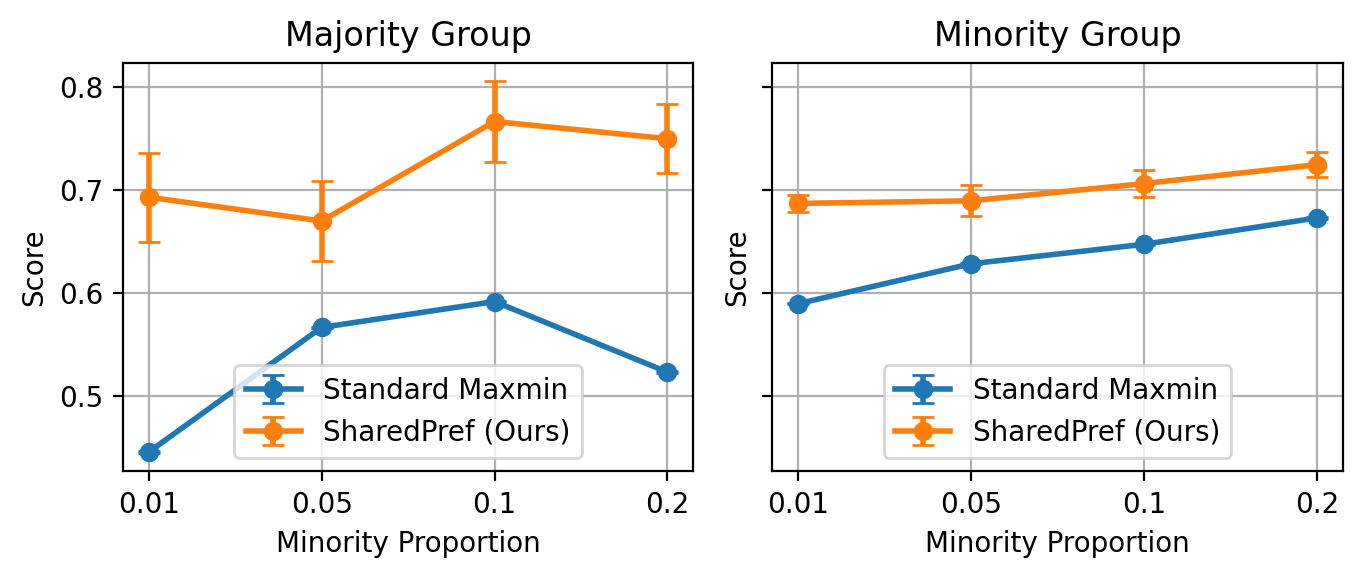

In [29]:
import matplotlib.pyplot as plt
import pandas as pd


# Prepare for first two subplots from df_maxmin
minority_props = sorted(df_maxmin["Minority Proportion"].unique())
minority_props_str = list(map(str, minority_props))

# Prepare group plots from df_sharedpref
groups = sorted(df_sharedpref["Group"].unique())
num_sharedpref_plots = len(groups)


fig, axes = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

for i, group in enumerate(groups):

    ax = axes[i]
    
    means_maxmin = df_maxmin.groupby("Minority Proportion")[f"Score {group} Group"].mean().reindex(minority_props)
    ses_maxmin = df_maxmin.groupby("Minority Proportion")[f"Score {group} Group"].sem().reindex(minority_props)

    ax.errorbar(
        minority_props_str,
        means_maxmin,
        yerr=ses_maxmin,
        linewidth=2.,
        marker="o",
        linestyle="-",
        capsize=4,
        label="Standard Maxmin"
    )

    
    df_group = df_sharedpref[df_sharedpref["Group"] == group]
    means_sharedpref = df_group.groupby("Minority Proportion")["Score"].mean().reindex(minority_props)
    ses_sharedpref = df_group.groupby("Minority Proportion")["Score"].sem().reindex(minority_props)

    ax.errorbar(
        minority_props_str,
        means_sharedpref,
        yerr=ses_sharedpref,
        linewidth=2.,
        fmt="o-",
        capsize=4,
        label="SharedPref (Ours)"
    )
    ax.set_ylabel("Score")
    ax.set_title(f"{group} Group")
    ax.set_xlabel("Minority Proportion")
    ax.set_xticks(range(len(minority_props_str)))
    ax.set_xticklabels(minority_props_str)
    ax.grid(True)
    ax.legend(loc="lower center")

plt.tight_layout()
plt.show()

## Win Rate

In [30]:
SP_PATH = "/home/mb1921/pluralistic_rlhf/experiments/exp1_shared_pref_pointwise_inv_pref/results/combined_results.csv"
sharedpref_combined_df = pd.read_csv(SP_PATH)
sharedpref_combined_df["minority_score"] = 0.7 * sharedpref_combined_df["ppo_positiveness"] + 0.3 * sharedpref_combined_df["ppo_conciseness"]
sharedpref_combined_df["majority_score"] = sharedpref_combined_df["ppo_conciseness"]
sharedpref_combined_df.head(3)

,Unnamed: 0,review,query,responses,positiveness,token_length,normalized_token_length,conciseness,group_id,group_score,...,ppo_conciseness,ppo_positiveness,seed,k,Minority Proportion,ppo_negativeness,group score 0,group score 1,minority_score,majority_score
0,0,I love sci-fi and am willing to put up with a ...,I love sci-fi and am,['I love sci-fi and am a big fan of the TV ser...,[0.99387699 0.96150589],[41 99],[0.39805825 0.96116505],[0.60194175 0.03883495],0,[0.60194175 0.03883495],...,0.872549,0.972168,5,2,0.05,0.027832,0.872549,0.942283,0.942283,0.872549
1,1,"Worth the entertainment value of a rental, esp...",Worth the entertainment value of a,['Worth the entertainment value of a couple of...,[0.98670667 0.1594373 ],[50 99],[0.48543689 0.96116505],[0.51456311 0.03883495],0,[0.51456311 0.03883495],...,0.901961,0.989767,5,2,0.05,0.010233,0.901961,0.963425,0.963425,0.901961
2,2,its a totally average film with a few semi-alr...,its a totally,"[""its a totally different atmosphere, I found ...",[0.95643008 0.98711884],[95 95],[0.9223301 0.9223301],[0.0776699 0.0776699],0,[0.0776699 0.0776699],...,0.941176,0.991261,5,2,0.05,0.008739,0.941176,0.976235,0.976235,0.941176


In [31]:
GOLD_PATH = "/home/mb1921/pluralistic_rlhf/experiments/exp1_oracle/results/ppo_eval/imdb_gold_combined.csv"

gold_combined_df = pd.read_csv(GOLD_PATH)
gold_combined_df = gold_combined_df.groupby("query_id", group_keys=False).sample(n=1, random_state=42)
gold_combined_df["majority_score"] = gold_combined_df["ppo_conciseness"]
gold_combined_df["minority_score"] = 0.7*gold_combined_df["ppo_positiveness"] + 0.3*gold_combined_df["ppo_conciseness"]
gold_combined_df.head(3)

,Unnamed: 0,review,query,responses,query_id,token_length,normalized_token_length,positiveness,ppo_responses,ppo_token_length,ppo_conciseness,ppo_positiveness,seed,majority_score,minority_score
0,0,I love sci-fi and am willing to put up with a ...,I love sci-fi and am,I love sci-fi and am so used to seeing a movie...,0,99,0.961165,0.481773,I love sci-fi and am a huge fan of the original.,14,0.864078,0.978883,73,0.864078,0.944441
450003,3,"Worth the entertainment value of a rental, esp...",Worth the entertainment value of a,Worth the entertainment value of a good movie....,1,99,0.961165,0.159437,Worth the entertainment value of a DVD.,9,0.910891,0.982986,14,0.910891,0.961357
250004,4,its a totally average film with a few semi-alr...,its a totally,its a totally different way of viewing things....,2,41,0.398058,0.981294,its a totally enjoyable movie.,6,0.941176,0.994904,94,0.941176,0.978786


In [32]:
MAXMIN_PATH = "/home/mb1921/pluralistic_rlhf/experiments/exp1_standard_maxmin_pointwise_inv_pref/results/combined_results.csv"
maxmin_combined_df = pd.read_csv(MAXMIN_PATH)
maxmin_combined_df["minority_score"] = 0.7 * maxmin_combined_df["ppo_positiveness"] + 0.3 * maxmin_combined_df["ppo_conciseness"]
maxmin_combined_df["majority_score"] = maxmin_combined_df["ppo_conciseness"]
maxmin_combined_df.head(3)

,Unnamed: 0,review,query,responses,positiveness,token_length,normalized_token_length,conciseness,group_id,group_score,...,ppo_token_length,ppo_conciseness,ppo_positiveness,seed,Minority Proportion,ppo_negativeness,group score 0,group score 1,minority_score,majority_score
0,0,I love sci-fi and am willing to put up with a ...,I love sci-fi and am,"[""I love sci-fi and am so used to seeing a mov...",[0.4817732 0.99511296],[99 45],[0.96116505 0.4368932 ],[0.03883495 0.5631068 ],0,[0.03883495 0.5631068 ],...,42,0.592233,0.992610,73,0.1,0.007390,0.592233,0.872497,0.872497,0.592233
1,1,"Worth the entertainment value of a rental, esp...",Worth the entertainment value of a,['Worth the entertainment value of a couple of...,[0.98670667 0.697905 ],[50 13],[0.48543689 0.12621359],[0.51456311 0.87378641],1,[0.8450636 0.75066943],...,9,0.912621,0.982367,73,0.1,0.017633,0.912621,0.961443,0.961443,0.912621
2,2,its a totally average film with a few semi-alr...,its a totally,"[""its a totally different atmosphere, I found ...",[0.95643008 0.98902953],[95 81],[0.9223301 0.78640777],[0.0776699 0.21359223],0,[0.0776699 0.21359223],...,64,0.378641,0.941932,73,0.1,0.058068,0.378641,0.772945,0.772945,0.378641


In [42]:
EXP_SHAREDREP_ABLATION = "/home/mb1921/pluralistic_rlhf/experiments/shared_pref_pointwise_ablation_inv_pref/results/combined_results.csv"
sharedpref_ablation_combined_df = pd.read_csv(EXP_SHAREDREP_ABLATION)
sharedpref_ablation_combined_df["minority_score"] = 0.7 * sharedpref_ablation_combined_df["ppo_positiveness"] + 0.3 * sharedpref_ablation_combined_df["ppo_conciseness"]
sharedpref_ablation_combined_df["majority_score"] = sharedpref_ablation_combined_df["ppo_conciseness"]
sharedpref_ablation_combined_df.head(3)

NameError: name 'sharedpref_ablation_comnined_df' is not defined

,Unnamed: 0,review,query,responses,positiveness,token_length,normalized_token_length,conciseness,group_id,group_score,...,ppo_conciseness,ppo_positiveness,seed,k,Minority Proportion,ppo_negativeness,group score 0,group score 1,minority_score,majority_score
0,0,I love sci-fi and am willing to put up with a ...,I love sci-fi and am,"[""I love sci-fi and am very into the genre, bu...",[0.00651848 0.01148003],[99 99],[0.96116505 0.96116505],[0.03883495 0.03883495],0,[0.03883495 0.03883495],...,0.643564,0.991474,16,32,0.1,0.008526,0.643564,0.887101,0.887101,0.643564
1,1,"Worth the entertainment value of a rental, esp...",Worth the entertainment value of a,['Worth the entertainment value of a good movi...,[0.1594373 0.98977703],[99 10],[0.96116505 0.09708738],[0.03883495 0.90291262],0,[0.03883495 0.90291262],...,0.742574,0.995125,16,32,0.1,0.004875,0.742574,0.919360,0.919360,0.742574
2,2,its a totally average film with a few semi-alr...,its a totally,"[""its a totally different and totally differen...",[0.9959805 0.98902953],[95 81],[0.9223301 0.78640777],[0.0776699 0.21359223],0,[0.0776699 0.21359223],...,0.702970,0.986763,16,32,0.1,0.013237,0.702970,0.901625,0.901625,0.702970


### SharedRep Ablation

In [57]:
import pandas as pd

# Step 1: Merge SR and MM on proportion + question (MM has no k)
sr_merged = pd.merge(
    sharedpref_ablation_combined_df[["review", "majority_score", "minority_score", "k", "Minority Proportion"]],
    gold_combined_df[["review", "minority_score", "majority_score"]],
    on=["review"],
    suffixes=('_sr', '_gold')
)

# Step 2: Compute win for each row
sr_merged["min_win"] = (sr_merged["minority_score_sr"] > sr_merged["minority_score_gold"]).astype(int)
sr_merged["maj_win"] = (sr_merged["majority_score_sr"] > sr_merged["majority_score_gold"]).astype(int)


# Step 3: Compute win rate by k and proportion
sr_win_rates = sr_merged.groupby(["k", "Minority Proportion"])[["min_win", "maj_win"]].mean().reset_index()

sem = sr_merged.groupby(["k", "Minority Proportion"])[["min_win", "maj_win"]].sem().reset_index()
sr_win_rates["min_win_sem"] = sem["min_win"]
sr_win_rates["maj_win_sem"] = sem["maj_win"]

# sr_win_rates["min_win_rate_percent"] = (sr_win_rates["min_win"] * 100).round(2)
# sr_win_rates["maj_win_rate_percent"] = (sr_win_rates["maj_win"] * 100).round(2)

# Loop through unique Minority Proportion values
for prop in sr_win_rates["Minority Proportion"].unique():
    # Filter and select only the needed columns
    filtered = sr_win_rates[sr_win_rates["Minority Proportion"] == prop][["k", "min_win", "maj_win", "min_win_sem", "maj_win_sem"]]
    
    # Clean filename: remove dot from proportion
    filename = f"/home/mb1921/sharedrep-rlhf/figures/imdb/sharedrep_ablation/data/winrate_prop_{prop}.csv"
    
    # Save to CSV
    filtered.to_csv(filename, index=False)

# Display
sr_win_rates

,k,Minority Proportion,min_win,maj_win,min_win_sem,maj_win_sem
0,2,0.05,0.395909,0.544442,0.001372,0.001397
1,2,0.10,0.322654,0.400978,0.001197,0.001255
2,4,0.05,0.215270,0.172748,0.001153,0.001060
3,4,0.10,0.260752,0.138915,0.001124,0.000886
4,16,0.05,0.196853,0.026772,0.001115,0.000453
5,16,0.10,0.199835,0.025789,0.001122,0.000445
6,32,0.05,0.342632,0.282519,0.001331,0.001263
7,32,0.10,0.248934,0.173456,0.001213,0.001062


<BarContainer object of 4 artists>

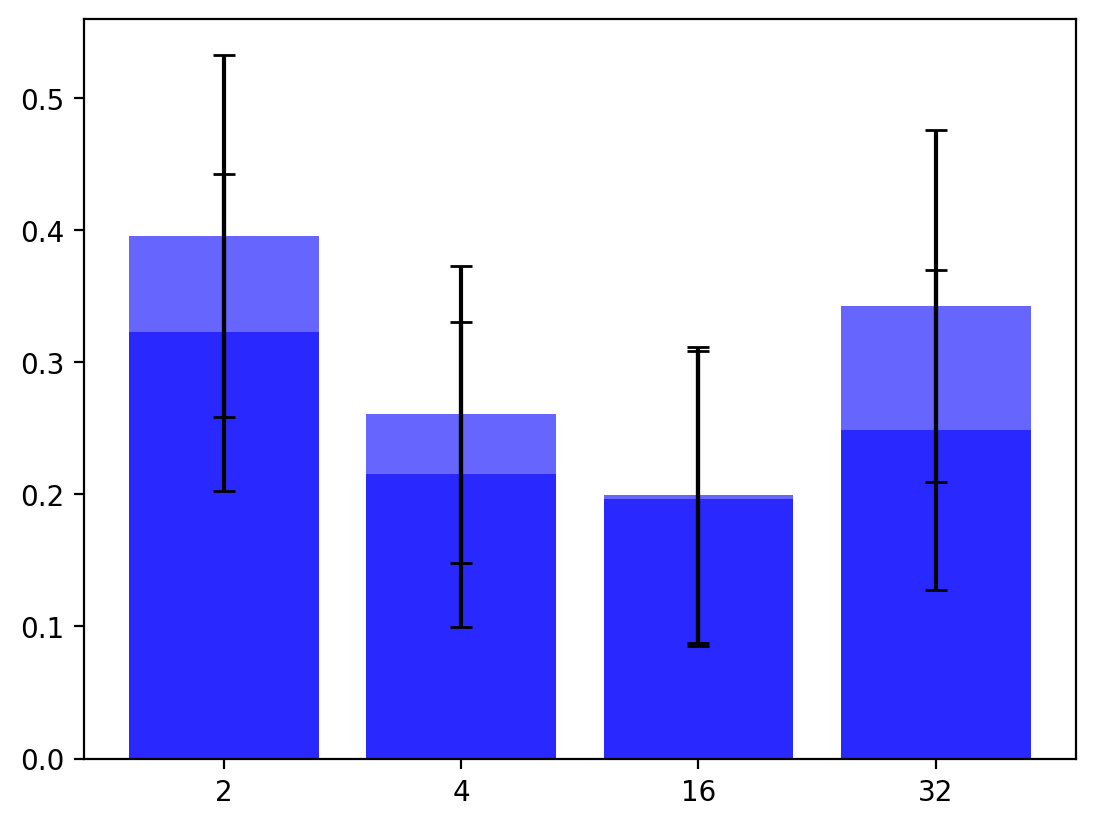

In [61]:
sr_win_rates[sr_win_rates["Minority Proportion"] == 0.1]

plt.bar(
    sr_win_rates[sr_win_rates["Minority Proportion"] == 0.1].sort_values("k")["k"].astype(str),
    sr_win_rates[sr_win_rates["Minority Proportion"] == 0.1].sort_values("k")["min_win"],
    yerr=sr_win_rates[sr_win_rates["Minority Proportion"] == 0.1].sort_values("k")["min_win_sem"] * 100,
    label="Minority Win Rate",
    alpha=0.6,
    color="blue",
    capsize=4
)

plt.bar(
    sr_win_rates[sr_win_rates["Minority Proportion"] == 0.05].sort_values("k")["k"].astype(str),
    sr_win_rates[sr_win_rates["Minority Proportion"] == 0.05].sort_values("k")["min_win"],
    yerr=sr_win_rates[sr_win_rates["Minority Proportion"] == 0.05].sort_values("k")["min_win_sem"] * 100,
    label="Minority Win Rate",
    alpha=0.6,
    color="blue",
    capsize=4
)

### SharedRep

In [33]:
import pandas as pd

# Step 1: Merge SR and MM on proportion + question (MM has no k)
sr_merged = pd.merge(
    sharedpref_combined_df[["review", "majority_score", "minority_score", "k", "Minority Proportion"]],
    gold_combined_df[["review", "minority_score", "majority_score"]],
    on=["review"],
    suffixes=('_sr', '_gold')
)

# Step 2: Compute win for each row
sr_merged["min_win"] = (sr_merged["minority_score_sr"] > sr_merged["minority_score_gold"]).astype(int)
sr_merged["maj_win"] = (sr_merged["majority_score_sr"] > sr_merged["majority_score_gold"]).astype(int)


# Step 3: Compute win rate by k and proportion
sr_win_rates = sr_merged.groupby(["k", "Minority Proportion"])[["min_win", "maj_win"]].mean().reset_index()
sr_win_rates["min_win_rate_percent"] = (sr_win_rates["min_win"] * 100).round(2)
sr_win_rates["maj_win_rate_percent"] = (sr_win_rates["maj_win"] * 100).round(2)

# Display
sr_win_rates


,k,Minority Proportion,min_win,maj_win,min_win_rate_percent,maj_win_rate_percent
0,2,0.01,0.252624,0.213119,25.26,21.31
1,2,0.05,0.260090,0.153733,26.01,15.37
2,2,0.10,0.317961,0.319519,31.80,31.95
3,2,0.20,0.314881,0.260393,31.49,26.04


In [28]:
import pandas as pd

# Step 1: Merge SR and MM on proportion + question (MM has no k)
mm_merged = pd.merge(
    maxmin_combined_df[["review", "majority_score", "minority_score", "Minority Proportion"]],
    gold_combined_df[["review", "minority_score", "majority_score"]],
    on=["review"],
    suffixes=('_sr', '_gold')
)

# Step 2: Compute win for each row
mm_merged["min_win"] = (mm_merged["minority_score_sr"] > mm_merged["minority_score_gold"]).astype(int)
mm_merged["maj_win"] = (mm_merged["majority_score_sr"] > mm_merged["majority_score_gold"]).astype(int)


# Step 3: Compute win rate by k and proportion
mm_win_rates = mm_merged.groupby(["Minority Proportion"])[["min_win", "maj_win"]].mean().reset_index()
mm_win_rates["min_win_rate_percent"] = (mm_win_rates["min_win"] * 100).round(2)
mm_win_rates["maj_win_rate_percent"] = (mm_win_rates["maj_win"] * 100).round(2)

# Display
mm_win_rates

,Minority Proportion,min_win,maj_win,min_win_rate_percent,maj_win_rate_percent
0,0.01,0.213791,0.266730,21.38,26.67
1,0.05,0.252136,0.342522,25.21,34.25
2,0.10,0.283066,0.401381,28.31,40.14
3,0.20,0.239718,0.165215,23.97,16.52


## Tables

### Win Rate

In [29]:
k=2
win_rate_comparison = pd.merge(
    mm_win_rates[["Minority Proportion", "min_win_rate_percent", "maj_win_rate_percent"]],
    sr_win_rates[sr_win_rates["k"]==k][["Minority Proportion", "min_win_rate_percent", "maj_win_rate_percent"]],
    on=["Minority Proportion"],
    suffixes=('_mm', '_sr')
)

win_rate_comparison

,Minority Proportion,min_win_rate_percent_mm,maj_win_rate_percent_mm,min_win_rate_percent_sr,maj_win_rate_percent_sr
0,0.01,21.38,26.67,25.26,21.31
1,0.05,25.21,34.25,26.01,15.37
2,0.10,28.31,40.14,31.80,31.95
3,0.20,23.97,16.52,31.49,26.04


### Mean Score

In [30]:
# SharedRep
k = 2
df_k = sharedpref_combined_df[sharedpref_combined_df["k"] == k].groupby("Minority Proportion")

x = sorted(df_k["Minority Proportion"].unique())
mean_min = df_k["minority_score"].mean()
sem_min = df_k["minority_score"].sem()
mean_maj = df_k["majority_score"].mean()
sem_maj = df_k["majority_score"].sem()

shared_rep_mean_score = pd.DataFrame({
    "Minority Proportion": mean_min.index,
    "mean_minority_score": mean_min.values,
    "sem_minority_score": sem_min.values,
    "mean_majority_score": mean_maj.values,
    "sem_majority_score": sem_maj.values    
})


# Maxmin
mm_grouped = maxmin_combined_df.groupby("Minority Proportion")

x = sorted(mm_grouped["Minority Proportion"].unique())
mean_min = mm_grouped["minority_score"].mean()
sem_min = mm_grouped["minority_score"].sem()
mean_maj = mm_grouped["majority_score"].mean()
sem_maj = mm_grouped["majority_score"].sem()

maxmin_mean_score = pd.DataFrame({
    "Minority Proportion": mean_min.index,
    "mean_minority_score": mean_min.values,
    "sem_minority_score": sem_min.values,
    "mean_majority_score": mean_maj.values,
    "sem_majority_score": sem_maj.values
})


mean_score_comparison = pd.merge(
    maxmin_mean_score,
    shared_rep_mean_score,
    on=["Minority Proportion"],
    suffixes=('_mm', '_sr')     
)
mean_score_comparison


,Minority Proportion,mean_minority_score_mm,sem_minority_score_mm,mean_majority_score_mm,sem_majority_score_mm,mean_minority_score_sr,sem_minority_score_sr,mean_majority_score_sr,sem_majority_score_sr
0,0.01,0.589612,0.000616,0.445243,0.000768,0.687198,0.000575,0.693248,0.000373
1,0.05,0.628440,0.000601,0.566553,0.000732,0.689723,0.000587,0.670058,0.000373
2,0.10,0.647401,0.000590,0.591683,0.000746,0.706462,0.000572,0.766877,0.000332
3,0.20,0.673009,0.000572,0.523052,0.000664,0.724814,0.000557,0.750169,0.000305


### Final Table

In [31]:
imdb_table = pd.merge(
    mean_score_comparison,
    win_rate_comparison,
    on=["Minority Proportion"],
    suffixes=('_mm', '_sr')
)
imdb_table

,Minority Proportion,mean_minority_score_mm,sem_minority_score_mm,mean_majority_score_mm,sem_majority_score_mm,mean_minority_score_sr,sem_minority_score_sr,mean_majority_score_sr,sem_majority_score_sr,min_win_rate_percent_mm,maj_win_rate_percent_mm,min_win_rate_percent_sr,maj_win_rate_percent_sr
0,0.01,0.589612,0.000616,0.445243,0.000768,0.687198,0.000575,0.693248,0.000373,21.38,26.67,25.26,21.31
1,0.05,0.628440,0.000601,0.566553,0.000732,0.689723,0.000587,0.670058,0.000373,25.21,34.25,26.01,15.37
2,0.10,0.647401,0.000590,0.591683,0.000746,0.706462,0.000572,0.766877,0.000332,28.31,40.14,31.80,31.95
3,0.20,0.673009,0.000572,0.523052,0.000664,0.724814,0.000557,0.750169,0.000305,23.97,16.52,31.49,26.04
